In [34]:
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import json
from shapely.geometry import Point, Polygon
from tqdm.notebook import tqdm

In [35]:
bunches = []

for bunch in range(50):
    
    with open('./Twitter Bunches (Thursday)/' + str(bunch) + '_de_bunch.json', 'r', encoding='utf-8') as f:
    
        D_read = json.load(f)
        bunches.extend(D_read) # extend instead of append

In [36]:
tweet_ids = []

for tweet in bunches:
    
    tweet_ids.append(tweet['id'])
    
len(np.unique(np.array(tweet_ids))), len(bunches)

(9951, 10000)

In [37]:
unique = { tweet['id'] : tweet for tweet in bunches }

In [38]:
matches = []

for (key, value) in unique.items():
    
    newDict = dict()
    
    try:
        
        if value['place']['bounding_box']['coordinates'] != None:
            
            newDict[key] = value
            
            matches.append(newDict)
    except:
        
        None

In [39]:
results_list = []

for i in matches:
    
    empty_dict = {}
    
    empty_dict['Tweet ID'] = list(i.keys())[0]
    
    values_list = list(i.values())[0]
    
    empty_dict['Created at'] = pd.to_datetime(values_list['created_at'])
    empty_dict['Full Text'] = values_list['full_text']
    empty_dict['User Name'] = values_list['user']['name']
    empty_dict['User Alias'] = values_list['user']['screen_name']
    empty_dict['Place ID'] = values_list['place']['id']
    empty_dict['Place Name'] = values_list['place']['name']
    empty_dict['Country Code'] = values_list['place']['country_code']
    empty_dict['Country Name'] = values_list['place']['country']
    empty_dict['Bounding Box'] = values_list['place']['bounding_box']['coordinates'][0]
    
    
    bbox = Polygon(values_list['place']['bounding_box']['coordinates'][0])
    
    latitude = bbox.centroid.xy[1][0]
    longitude = bbox.centroid.xy[0][0]
    
    coord = Point(longitude, latitude)
    
    empty_dict['Tweet Coordinates'] = coord
    empty_dict['Retweet Count'] = values_list['retweet_count']
    empty_dict['Favorite Count'] = values_list['favorite_count']
     
    empty_dict['User Location'] = values_list['user']['location']
    empty_dict['User Followers'] = values_list['user']['followers_count']
    empty_dict['User Friends'] = values_list['user']['friends_count']
    empty_dict['Registration Date'] = values_list['user']['created_at']
    
    tweet_url = 'https://twitter.com/{}/status/{}'.format(values_list['user']['screen_name'], values_list['id'])
    empty_dict['Tweet URL'] = tweet_url
    
    results_list.append(empty_dict)

In [40]:
results_df = pd.DataFrame(results_list)

In [41]:
gdf = gpd.GeoDataFrame(results_df, geometry=results_df['Tweet Coordinates'])
# gdf = gdf.set_crs(epsg=4326)

In [42]:
mapbox_access_token = open("mapbox_token.txt").read()

In [43]:
data = [
    go.Scattermapbox(
    lon = gdf['geometry'].x.values,
    lat = gdf['geometry'].y.values,
    mode = 'markers',
    marker = go.scattermapbox.Marker(
    size = 3.5,
    color='red',
    #symbol = 'ferry'
    ),
    text = gdf['Place Name'],
    #text = "Vessel name: <em> " + df.Name + "</em><br>" + 
    #    "Destination Port: " + df.Destination_Port + "<br>" +
    #    "Dead weight tonnage: " + df.DWT.astype(str) + " tons"
    #text = 'Vessel name = ' + str(df.Name) + ', Dead weight tonnage: ' + str(df.DWT) + 'm³',
    )
]

layout = go.Layout(
    autosize=True,
    hovermode='closest',
    width = 800, 
    height = 800,
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=51,
            lon=10
        ),
        pitch=0,
        zoom=5
    ),
)
                  
fig = go.Figure(data = data, layout = layout)
iplot(fig, filename="geomap_twitter_neu")

In [44]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [45]:
coordinates_data = {'lon': gdf['geometry'].x, 'lat': gdf['geometry'].y}
coordinates_df = pd.DataFrame(data=coordinates_data)

C:\Users\wolfg\Anaconda3\envs\webscraping\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1

C:\Users\wolfg\Anaconda3\envs\webscraping\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1

C:\Users\wolfg\Anaconda3\envs\webscraping\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1

C:\U

Text(0, 0.5, 'Sum of Squared Distances')

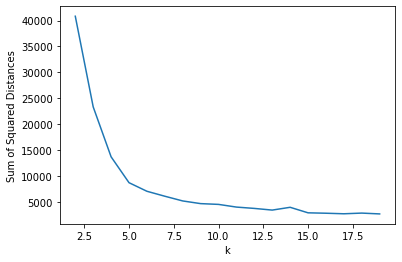

In [46]:
ssd = []

for i in range(2, 20):
    # Find clusters
    km = MiniBatchKMeans(n_clusters=i)
    km.fit_predict(coordinates_df)
    
    # Label cluster centers
    centers = km.cluster_centers_
    
    # Calculate sum of squared distances
    ssd.append(km.inertia_)
    
    # Get cluster center
    coordinates_df['cluster'] = km.labels_
    
plt.plot(range(2,20), ssd)
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')

In [47]:
del coordinates_df['cluster']

range_n_clusters = range(2, 20)

X = np.array(coordinates_df)

for n_clusters in range_n_clusters:
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.5035575871556137
For n_clusters = 3 The average silhouette_score is : 0.52595826819953
For n_clusters = 4 The average silhouette_score is : 0.5800715059790145
For n_clusters = 5 The average silhouette_score is : 0.6144091482133723
For n_clusters = 6 The average silhouette_score is : 0.6158093308978937
For n_clusters = 7 The average silhouette_score is : 0.5994224679231596
For n_clusters = 8 The average silhouette_score is : 0.5953419625524307
For n_clusters = 9 The average silhouette_score is : 0.6062270238636666
For n_clusters = 10 The average silhouette_score is : 0.6036279301184655
For n_clusters = 11 The average silhouette_score is : 0.5943092961685204
For n_clusters = 12 The average silhouette_score is : 0.5955142779207764
For n_clusters = 13 The average silhouette_score is : 0.5538285643358677
For n_clusters = 14 The average silhouette_score is : 0.6029401375097045
For n_clusters = 15 The average silhouette_score is : 0.56552

In [48]:
clusterer = KMeans(n_clusters=6, random_state=10)
cluster_labels = clusterer.fit_predict(X)
centers = clusterer.cluster_centers_
gdf['Cluster Label'] = cluster_labels

In [49]:
centers_gdf = gpd.GeoDataFrame(centers, geometry=[Point(point) for point in centers])

In [50]:
import seaborn as sns
palette = sns.color_palette(None, 6).as_hex()

In [51]:
colors = palette

traces = []

for cluster_num in set(cluster_labels):
    
    sub_df = gdf[gdf['Cluster Label'] == cluster_num]
    
    trace = go.Scattermapbox(
    lon = sub_df['geometry'].x.values,
    lat = sub_df['geometry'].y.values,
    mode = 'markers',
    marker = go.scattermapbox.Marker(
    size = 5,
    color= colors[cluster_num],
    #symbol = 'star'
    ),
    text = sub_df['Place Name'] + "<br>" +
        "Cluster ID: " + str(cluster_num)
    )
    
    traces.append(trace)
    
cluster_center_trace = go.Scattermapbox(
    lon = centers_gdf['geometry'].x.values,
    lat = centers_gdf['geometry'].y.values,
    mode = 'markers',
    marker = go.scattermapbox.Marker(
    size = 7,
    color='red',
    #symbol = 'star'
    ),
    text = list(range(7))
    )

traces.append(cluster_center_trace)
    
fig = go.Figure(data = traces)

layout = go.Layout(
    autosize=True,
    hovermode='closest',
    width = 800, 
    height = 800,
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=51,
            lon=10
        ),
        pitch=0,
        zoom=5
    ),
)

fig.layout.update(layout)
                  
iplot(fig, filename="geomap_twitter_cluster")

In [22]:
# https://hub.arcgis.com/datasets/b8d0cc7735774bed8e6df1c5410394a4_0

germany_borders = gpd.read_file("https://opendata.arcgis.com/datasets/b8d0cc7735774bed8e6df1c5410394a4_0.geojson")

In [23]:
indices_list = []

for state_num in tqdm(range(len(germany_borders))):
    
    state_index = gdf.within(germany_borders.loc[state_num, 'geometry'])
    
    # https://automating-gis-processes.github.io/CSC18/lessons/L4/point-in-polygon.html
    
    indices_list.append(state_index)

  0%|          | 0/16 [00:00<?, ?it/s]

In [24]:
sub_gdf_list = []

for idx, i in enumerate(indices_list):
    
    sub_gdf = gdf[i]
    sub_gdf['State'] = germany_borders.loc[idx]['GEN']
    sub_gdf = pd.DataFrame(sub_gdf)
    
    sub_gdf_list.append(sub_gdf)

In [25]:
merged_df = pd.concat(sub_gdf_list)

In [26]:
merged_df.head()

,Tweet ID,Created at,Full Text,User Name,User Alias,Place ID,Place Name,Country Code,Country Name,Bounding Box,...,Retweet Count,Favorite Count,User Location,User Followers,User Friends,Registration Date,Tweet URL,geometry,Cluster Label,State
34,1382786977506938880,2021-04-15 20:04:41+00:00,@GabileinDe So ist es oft,Deutsche Seemannsmission @Nordkirche,DSM_Nordkirche,d2de95ce61028811,Pinneberg,DE,Germany,"[[9.763698, 53.608768], [9.829102, 53.608768],...",...,0,0,"Hamburg, Schleswig-Holstein, Mecklenburg-Vorpo...",4031,5001,Fri Jun 24 13:03:29 +0000 2016,https://twitter.com/DSM_Nordkirche/status/1382...,POINT (9.79640 53.64639),4,Schleswig-Holstein
108,1382785318290604034,2021-04-15 19:58:05+00:00,@GabileinDe Rechtsstreit um knapp 1 Mrd. Us$,Deutsche Seemannsmission @Nordkirche,DSM_Nordkirche,d2de95ce61028811,Pinneberg,DE,Germany,"[[9.763698, 53.608768], [9.829102, 53.608768],...",...,0,1,"Hamburg, Schleswig-Holstein, Mecklenburg-Vorpo...",4031,5001,Fri Jun 24 13:03:29 +0000 2016,https://twitter.com/DSM_Nordkirche/status/1382...,POINT (9.79640 53.64639),4,Schleswig-Holstein
158,1382784299913596930,2021-04-15 19:54:02+00:00,@Tarnkappenrdlr Gute Nacht! 🌙💤,Michael,mtpb_eu,1b9b5e83e647a7ed,Kiel,DE,Germany,"[[10.032937, 54.2506929], [10.218568, 54.25069...",...,0,0,"Kiel, Germany",75,210,Sun Mar 01 09:00:24 +0000 2015,https://twitter.com/mtpb_eu/status/13827842999...,POINT (10.12575 54.34180),4,Schleswig-Holstein
207,1382782582551678981,2021-04-15 19:47:13+00:00,"@EsthiPesthi Mal sehen, hab ich ihr gesagt.......",Matthias Ristau,matthias_ristau,d2de95ce61028811,Pinneberg,DE,Germany,"[[9.763698, 53.608768], [9.829102, 53.608768],...",...,0,0,"Pinneberg, Deutschland",757,2383,Fri Jun 24 12:50:43 +0000 2016,https://twitter.com/matthias_ristau/status/138...,POINT (9.79640 53.64639),4,Schleswig-Holstein
224,1382782223846416387,2021-04-15 19:45:47+00:00,So ziemlich alle Fernsehprogramme kotzen einen...,GuNi,GuNi16297608,f03f4fd22fd009d8,Preetz,DE,Germany,"[[10.233175, 54.198271], [10.313413, 54.198271...",...,0,0,,186,519,Fri Oct 12 19:52:44 +0000 2018,https://twitter.com/GuNi16297608/status/138278...,POINT (10.27329 54.22818),4,Schleswig-Holstein


In [27]:
tweets_count = merged_df.groupby('State').count()['Tweet ID'].sort_values(ascending=False)
tweets_count = pd.DataFrame(tweets_count)
tweets_count.columns = ['Tweet Count']

In [28]:
states = ['Nordrhein-Westfalen', 'Berlin', 'Niedersachsen', 'Baden-Württemberg', 
          'Bayern', 'Hessen', 'Sachsen', 'Rheinland-Pfalz', 'Brandenburg',
         'Schleswig-Holstein', 'Mecklenburg-Vorpommern', 'Sachsen-Anhalt', 
          'Thüringen', 'Bremen', 'Saarland', 'Hamburg']

pop_data = [17947221, 3669491, 7993608, 11100394, 13124737, 6288080, 4071971, 
            4093903, 2521893, 2903773, 1608138, 2194782, 2133378, 681202, 986887, 1847253]

d = {'State': states, 'Pop': pop_data}
pop_df = pd.DataFrame(d)
pop_df = pop_df.set_index('State')

In [29]:
merged_pop_df = tweets_count.merge(pop_df, left_index=True, right_index=True)
merged_pop_df.head()

,Tweet Count,Pop
State,,
Nordrhein-Westfalen,1973,17947221
Berlin,1884,3669491
Niedersachsen,1116,7993608
Baden-Württemberg,1027,11100394
Bayern,1012,13124737


In [30]:
from scipy import stats

X = np.log(merged_pop_df['Pop'])
y= np.log(merged_pop_df['Tweet Count'])

slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

print(slope, intercept, r_value, p_value, std_err)

1.0634170364210063 -10.185304526237712 0.7299445666894703 0.0013267518794178343 0.2661290408604683


In [31]:
line = slope*X+intercept

trace_data = go.Scatter(
    x = X,
    y = y,
    mode = 'markers',
    marker = dict(symbol='circle'),
    text = list(merged_pop_df.index)
    # name='Equities',
    # hovertext=reshaped_df.iloc[:16,2].values
)

trace_line = go.Scatter(
                  x=X,
                  y=line,
                  mode='lines',
                  name='Fit'
                  )

annotation = go.Annotation(
                  x=13.5,
                  y=8,
                  text='$R^2 =' + str(round(r_value**2, 4)) + ', Y =' + str(round(slope, 4)) + 'X + ' + str(round(intercept,4)) + '$',
                  showarrow=False,
                  font=go.Font(size=12)
                  )

layout = go.Layout(
    title=go.layout.Title(
        text='Tweets and Population (state level)',
        xref='paper',
        x=0
    ),
    plot_bgcolor='rgb(229, 229, 229)',
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='Log Population',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Log Tweets sent',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    annotations=[annotation]
)

data = [trace_data, trace_line]

fig = go.Figure(data=data, layout=layout)


iplot(fig, filename = 'tweets_pop')

C:\Users\wolfg\Anaconda3\envs\webscraping\lib\site-packages\plotly\graph_objs\_deprecations.py:322: DeprecationWarning:

plotly.graph_objs.Font is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Font
  - plotly.graph_objs.layout.hoverlabel.Font
  - etc.


C:\Users\wolfg\Anaconda3\envs\webscraping\lib\site-packages\plotly\graph_objs\_deprecations.py:143: DeprecationWarning:

plotly.graph_objs.Annotation is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Annotation
  - plotly.graph_objs.layout.scene.Annotation




In [32]:
grouped_df = pd.DataFrame(merged_df.groupby(['State','Cluster Label']).count()['Tweet ID'])
grouped_df = grouped_df.stack().to_frame().reset_index()
grouped_df['Cluster Label'] = grouped_df['Cluster Label'].astype(str)
grouped_df.columns = ['State', 'Cluster Label', 'Col Name', 'Count']
grouped_df.head()

,State,Cluster Label,Col Name,Count
0,Baden-Württemberg,1,Tweet ID,963
1,Baden-Württemberg,3,Tweet ID,64
2,Bayern,0,Tweet ID,24
3,Bayern,1,Tweet ID,77
4,Bayern,3,Tweet ID,911


In [33]:
pd.crosstab(grouped_df['State'], grouped_df['Cluster Label'], values = grouped_df['Count'], aggfunc=np.sum, normalize='columns')

Cluster Label,0,1,2,3,4,5
State,,,,,,
Baden-Württemberg,0.000000,0.507376,0.000000,0.065641,0.000000,0.000000
Bayern,0.029593,0.040569,0.000000,0.934359,0.000000,0.000000
Berlin,0.000000,0.000000,0.755716,0.000000,0.000000,0.000000
Brandenburg,0.003699,0.000000,0.117930,0.000000,0.000000,0.000000
Bremen,0.000000,0.000000,0.000000,0.000000,0.081064,0.000000
Hamburg,0.000000,0.000000,0.000000,0.000000,0.006333,0.000000
Hessen,0.028360,0.299789,0.000000,0.000000,0.003800,0.005497
Mecklenburg-Vorpommern,0.001233,0.000000,0.086643,0.000000,0.071564,0.000000
Niedersachsen,0.125771,0.000000,0.000000,0.000000,0.588347,0.038937
